In [2]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np
from tqdm import tqdm

Algorithms

In [3]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

In [19]:
def bwgd(y, A, niter=60, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/2 - np.exp(-y / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde
   
    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde
           
    for iter in range(1, niter):
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
        x_tilde -= np.linalg.solve(hessian, gradient)

        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [14]:
def bwgd_smooth(y, A, niter=60, gamma=0.01, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y**2)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde

    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde


    for iter in range(1, niter):
        loss_values = (np.abs(A_tilde.T @ x_tilde) - y) ** 2
        epsilon = np.quantile(loss_values, gamma)

        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt(np.sum(A_tilde * ((np.outer(x_tilde,x_tilde) + epsilon * np.eye(d)) @ A_tilde), axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1/n) * A_tilde @ (alpha * (A_tilde.T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [6]:
def bwgd_smooth_loss(y, A, niter=60, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

     # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y**2)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde

    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde


    for iter in range(1, niter):
        loss_values = np.mean((np.abs(A_tilde.T @ x_tilde) - y) ** 2)
        epsilon = loss_values/2
        
        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt(np.sum(A_tilde * ((np.outer(x_tilde,x_tilde) + epsilon * np.eye(d)) @ A_tilde), axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1/n) * A_tilde @ (alpha * (A_tilde.T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

Spectral 2

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:33<00:00, 10.25s/it]


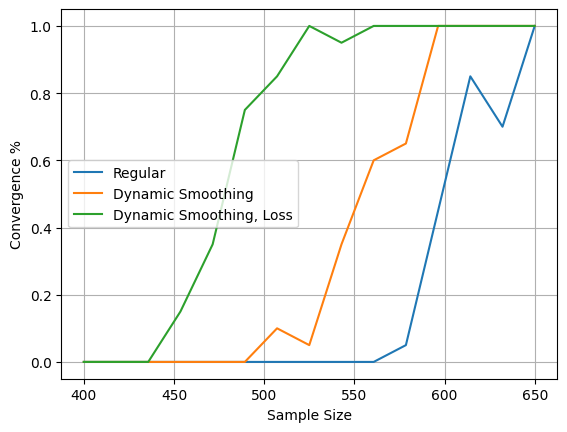

In [21]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with the 2nd spectral initialization
d = 200
ns = np.linspace(400, 650, 15)
conv_regular = []
conv_smooth = []
conv_smoothl = []
iters = 20

for n in tqdm(ns):
    n=int(n)
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    conv_smoothl_number = 0
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec2")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec2")
        x_hat3, iters3 = bwgd_smooth_loss(y2, A, init="spec2")

        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
        if min_error(x_hat3, x)[-1]<1e-9:
            conv_smoothl_number += 1
            
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)
    conv_smoothl.append(conv_smoothl_number/iters)

plt.plot(ns, conv_regular, label="Regular")
plt.plot(ns, conv_smooth, label="Dynamic Smoothing")
plt.plot(ns, conv_smoothl, label="Dynamic Smoothing, Loss")
plt.xlabel("Sample Size")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

In [61]:
def convergence_time(bwgd, init, samples, max_iter=60,  square=True,   num_trials = 50):
    d = 200                      
    
    # Initialize array: rows = iterations, cols = different sample sizes
    error_matrix = np.zeros((max_iter, len(samples)))
    
    for i, n in tqdm(enumerate(samples)):
        n = int(n)
        error_accumulator = np.zeros((max_iter,))
        converged_runs = 0
    
        for trial in range(num_trials):
            # Generate ground truth and data
            x = np.ones(d) / np.sqrt(d)
            A = np.random.randn(d, n)
            if square:
                y = np.square(A.T @ x)
            else:
                y = np.abs(A.T @ x)
    
            # Run the algorithm
            x_hat, iter_history = bwgd(y, A, init=init, niter=max_iter)
    
            # Compute errors at each iteration
            errors = min_error(x_hat, x)
            errors = np.array(errors)
            # Check for convergence
            if errors[-1] < 1e-8:
                # Pad with NaNs or extend with final error value
                if len(errors) < max_iter:
                    errors = np.concatenate([errors, np.full(max_iter - len(errors), errors[-1])])
                error_accumulator += errors[:max_iter]
                converged_runs += 1
    
        # Average over converged runs
        if converged_runs > 0:
            error_matrix[:, i] = error_accumulator / converged_runs
        else:
            error_matrix[:, i] = np.nan  # Mark as invalid if no convergence

    return error_matrix

In [62]:
samples = np.linspace(450, 650, 21)
max_iter = 60                          
err_bsl_spec2 = convergence_time(bwgd_smooth_loss, init="spec2", samples=samples, max_iter=max_iter, square=False)
err_bs_spec2 = convergence_time(bwgd_smooth, init="spec2", samples=samples, max_iter=max_iter, square=False)
err_b_spec2 = convergence_time(bwgd, init="spec2", samples=samples, max_iter=max_iter, square=True)

21it [03:45, 10.74s/it]
21it [03:15,  9.32s/it]
21it [02:16,  6.52s/it]


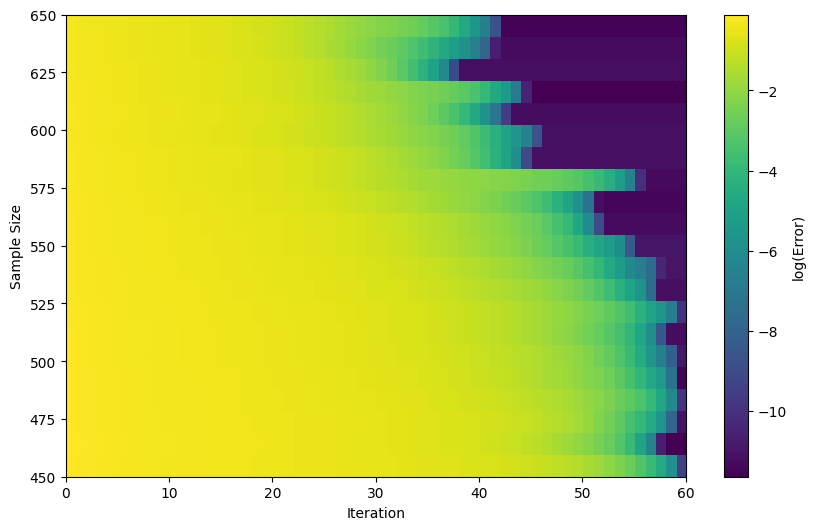

In [63]:
plt.figure(figsize=(10, 6))
plt.imshow(np.log10(err_bsl_spec2.T),  # Transpose the matrix
           aspect='auto',
           origin='lower',
           extent=[0, max_iter, samples[0], samples[-1]],  # Swap axes in extent
           cmap='viridis')

plt.colorbar(label='log(Error)')
plt.xlabel('Iteration')
plt.ylabel('Sample Size')
plt.grid(False)
plt.show()

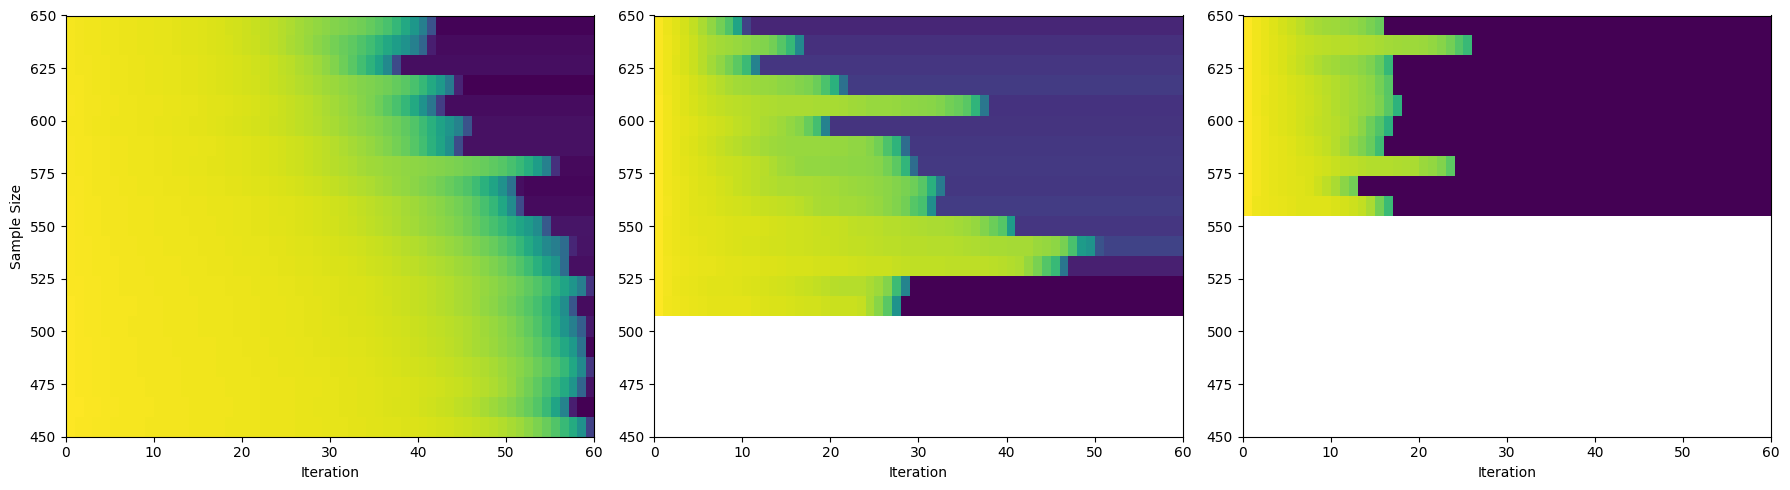

In [65]:
errors_spec2 = [err_bsl_spec2, err_bs_spec2, err_b_spec2]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i, (ax, err_matrix) in enumerate(zip(axs, error_matrices)):
    im = ax.imshow(np.log10(err_matrix.T),  # Transpose for correct orientation
                   aspect='auto',
                   origin='lower',
                   extent=[0, max_iter, samples[0], samples[-1]],
                   cmap='viridis')
    
    ax.set_xlabel('Iteration')
    if i == 0:
        ax.set_ylabel('Sample Size')
    ax.grid(False)

# Add one shared colorbar
cbar.set_label('log(Error)')

plt.tight_layout()
plt.show()

Spectral 1

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:55<00:00, 11.69s/it]


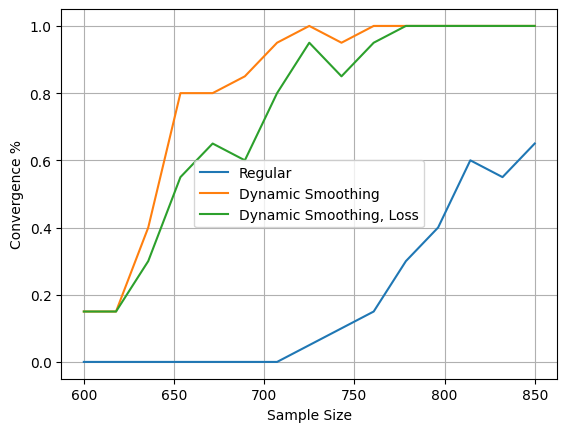

In [66]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with the 2nd spectral initialization
d = 200
ns = np.linspace(600, 850, 15)
conv_regular = []
conv_smooth = []
conv_smoothl = []
iters = 20

for n in tqdm(ns):
    n=int(n)
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    conv_smoothl_number = 0
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec1")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec1")
        x_hat3, iters3 = bwgd_smooth_loss(y2, A, init="spec1")

        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
        if min_error(x_hat3, x)[-1]<1e-9:
            conv_smoothl_number += 1
            
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)
    conv_smoothl.append(conv_smoothl_number/iters)

plt.plot(ns, conv_regular, label="Regular")
plt.plot(ns, conv_smooth, label="Dynamic Smoothing")
plt.plot(ns, conv_smoothl, label="Dynamic Smoothing, Loss")
plt.xlabel("Sample Size")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

21it [04:56, 14.13s/it]
21it [04:02, 11.55s/it]
21it [03:35, 10.28s/it]


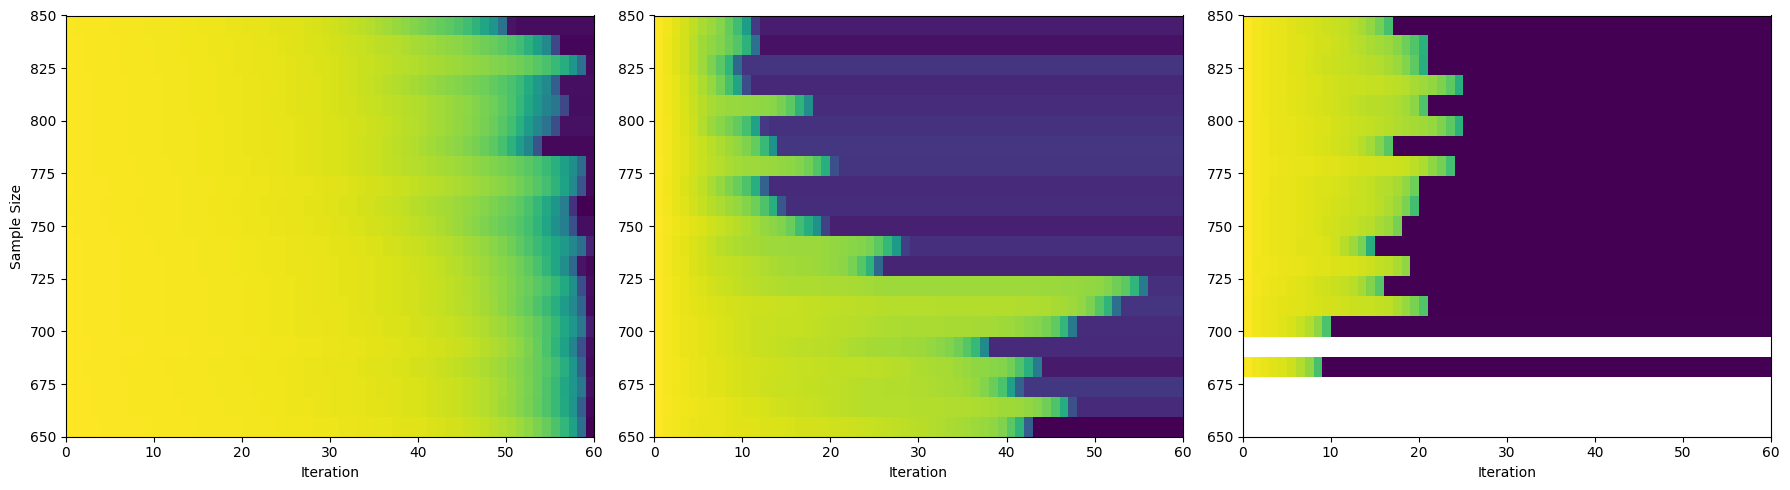

In [69]:
#Convergence time
samples = np.linspace(650, 850, 21)
max_iter = 60                          
err_bsl_spec1 = convergence_time(bwgd_smooth_loss, init="spec1", samples=samples, max_iter=max_iter, square=False)
err_bs_spec1 = convergence_time(bwgd_smooth, init="spec1", samples=samples, max_iter=max_iter, square=False)
err_b_spec1 = convergence_time(bwgd, init="spec1", samples=samples, max_iter=max_iter, square=True)

errors_spec1 = [err_bsl_spec1, err_bs_spec1, err_b_spec1]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns
for i, (ax, err_matrix) in enumerate(zip(axs, errors_spec1)):
    im = ax.imshow(np.log10(err_matrix.T),  # Transpose for correct orientation
                   aspect='auto',
                   origin='lower',
                   extent=[0, max_iter, samples[0], samples[-1]],
                   cmap='viridis')
    
    ax.set_xlabel('Iteration')
    if i == 0:
        ax.set_ylabel('Sample Size')
    ax.grid(False)

# Add one shared colorbar
cbar.set_label('log(Error)')

plt.tight_layout()
plt.show()


Random

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [18:22<00:00, 73.51s/it]


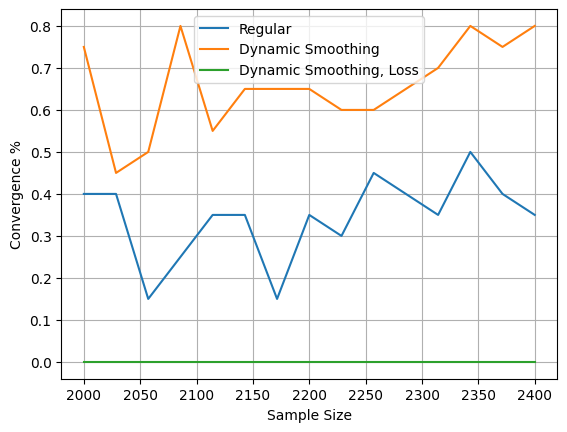

In [39]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with random init
d = 200
ns = np.linspace(2000, 2400, 15)
conv_regular = []
conv_smooth = []
conv_smoothl = []
iters = 20

for n in tqdm(ns):
    n=int(n)
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    conv_smoothl_number = 0
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="rand")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="rand")
        x_hat3, iters3 = bwgd_smooth_loss(y2, A, init="rand")

        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
        if min_error(x_hat3, x)[-1]<1e-9:
            conv_smoothl_number += 1
            
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)
    conv_smoothl.append(conv_smoothl_number/iters)

plt.plot(ns, conv_regular, label="Regular")
plt.plot(ns, conv_smooth, label="Dynamic Smoothing")
plt.plot(ns, conv_smoothl, label="Dynamic Smoothing, Loss")
plt.xlabel("Sample Size")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

21it [13:07, 37.52s/it]
21it [04:30, 12.86s/it]


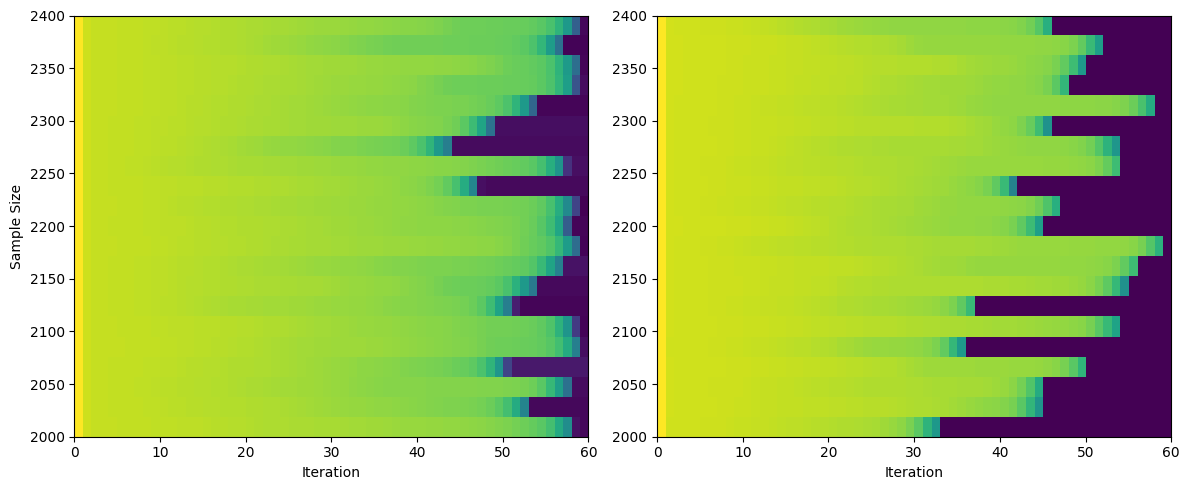

In [74]:
# Convergence time
#Convergence time
samples = np.linspace(2000, 2400, 21)
max_iter = 60                          
err_bs_rand = convergence_time(bwgd_smooth, init="rand", samples=samples, max_iter=max_iter, square=False)
err_b_rand = convergence_time(bwgd, init="rand", samples=samples, max_iter=max_iter, square=True)

errors_rand = [err_bs_rand, err_b_rand]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 3 columns
for i, (ax, err_matrix) in enumerate(zip(axs, errors_rand)):
    im = ax.imshow(np.log10(err_matrix.T),  # Transpose for correct orientation
                   aspect='auto',
                   origin='lower',
                   extent=[0, max_iter, samples[0], samples[-1]],
                   cmap='viridis')
    
    ax.set_xlabel('Iteration')
    if i == 0:
        ax.set_ylabel('Sample Size')
    ax.grid(False)

# Add one shared colorbar
cbar.set_label('log(Error)')

plt.tight_layout()
plt.show()


Dimension plot

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [08:03<00:00, 32.20s/it]


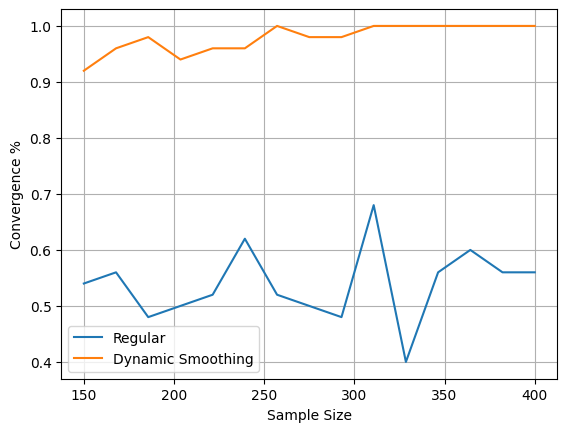

In [16]:
# % of Convergence for higher dimensions with n = dlog(d). Compares smooth and not smooth bwgd with the 2nd spectral initialization
ds = np.linspace(150, 400, 15)
conv_regular = []
conv_smooth = []
iters = 50

for d in tqdm(ds):
    d=int(d)
    n=d*3
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    
    error=[]
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec2")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec2")
    
        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)

plt.plot(ds, conv_regular, label="Regular")
plt.plot(ds, conv_smooth, label="Dynamic Smoothing")
plt.xlabel("Dimension")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

Heavy Tailed

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [07:52<00:00, 31.50s/it]


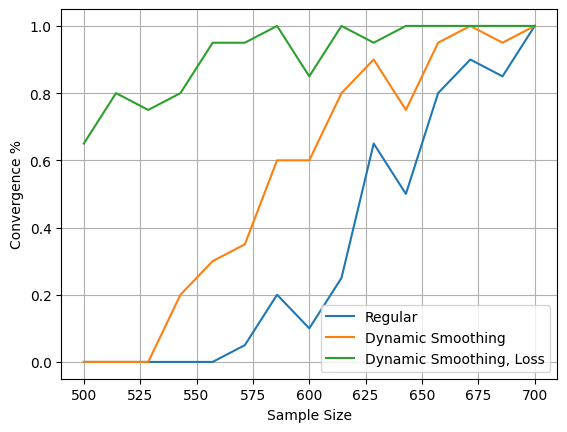

In [33]:
# % of Convergence for higher samples, keeping d=200. Compares smooth and not smooth bwgd with the 2nd spectral initialization
d = 200
ns = np.linspace(500, 700, 15)
conv_regular = []
conv_smooth = []
conv_smoothl = []
iters = 20

for n in tqdm(ns):
    n=int(n)
    # Plot 
    conv_regular_number = 0
    conv_smooth_number = 0
    conv_smoothl_number = 0
    for j in range(iters):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.standard_t(5, (d, n))
        y1 = np.square(A.T @ x)
        y2 = np.abs(A.T @ x)
            
        # Run the algorithm
        x_hat1, iters1 = bwgd(y1, A, init="spec2")
        x_hat2, iters2 = bwgd_smooth(y2, A, init="spec2")
        x_hat3, iters3 = bwgd_smooth_loss(y2, A, init="spec2")

        if min_error(x_hat1, x)[-1]<1e-9:
            conv_regular_number += 1
        if min_error(x_hat2, x)[-1]<1e-9:
            conv_smooth_number += 1
        if min_error(x_hat3, x)[-1]<1e-9:
            conv_smoothl_number += 1
            
    conv_regular.append(conv_regular_number/iters)
    conv_smooth.append(conv_smooth_number/iters)
    conv_smoothl.append(conv_smoothl_number/iters)

plt.plot(ns, conv_regular, label="Regular")
plt.plot(ns, conv_smooth, label="Dynamic Smoothing")
plt.plot(ns, conv_smoothl, label="Dynamic Smoothing, Loss")
plt.xlabel("Sample Size")
plt.ylabel("Convergence %")
plt.legend()
plt.grid(True)
plt.show()

In [76]:
def convergence_time_heavy_tail(bwgd, init, samples, max_iter=60,  square=True,   num_trials = 50):
    d = 200                      
    
    # Initialize array: rows = iterations, cols = different sample sizes
    error_matrix = np.zeros((max_iter, len(samples)))
    
    for i, n in tqdm(enumerate(samples)):
        n = int(n)
        error_accumulator = np.zeros((max_iter,))
        converged_runs = 0
    
        for trial in range(num_trials):
            # Generate ground truth and data
            x = np.ones(d) / np.sqrt(d)
            A = np.random.standard_t(5, (d, n))
            if square:
                y = np.square(A.T @ x)
            else:
                y = np.abs(A.T @ x)
    
            # Run the algorithm
            x_hat, iter_history = bwgd(y, A, init=init, niter=max_iter)
    
            # Compute errors at each iteration
            errors = min_error(x_hat, x)
            errors = np.array(errors)
            # Check for convergence
            if errors[-1] < 1e-8:
                # Pad with NaNs or extend with final error value
                if len(errors) < max_iter:
                    errors = np.concatenate([errors, np.full(max_iter - len(errors), errors[-1])])
                error_accumulator += errors[:max_iter]
                converged_runs += 1
    
        # Average over converged runs
        if converged_runs > 0:
            error_matrix[:, i] = error_accumulator / converged_runs
        else:
            error_matrix[:, i] = np.nan  # Mark as invalid if no convergence

    return error_matrix

21it [04:57, 14.15s/it]
21it [03:29, 10.00s/it]
21it [03:37, 10.35s/it]


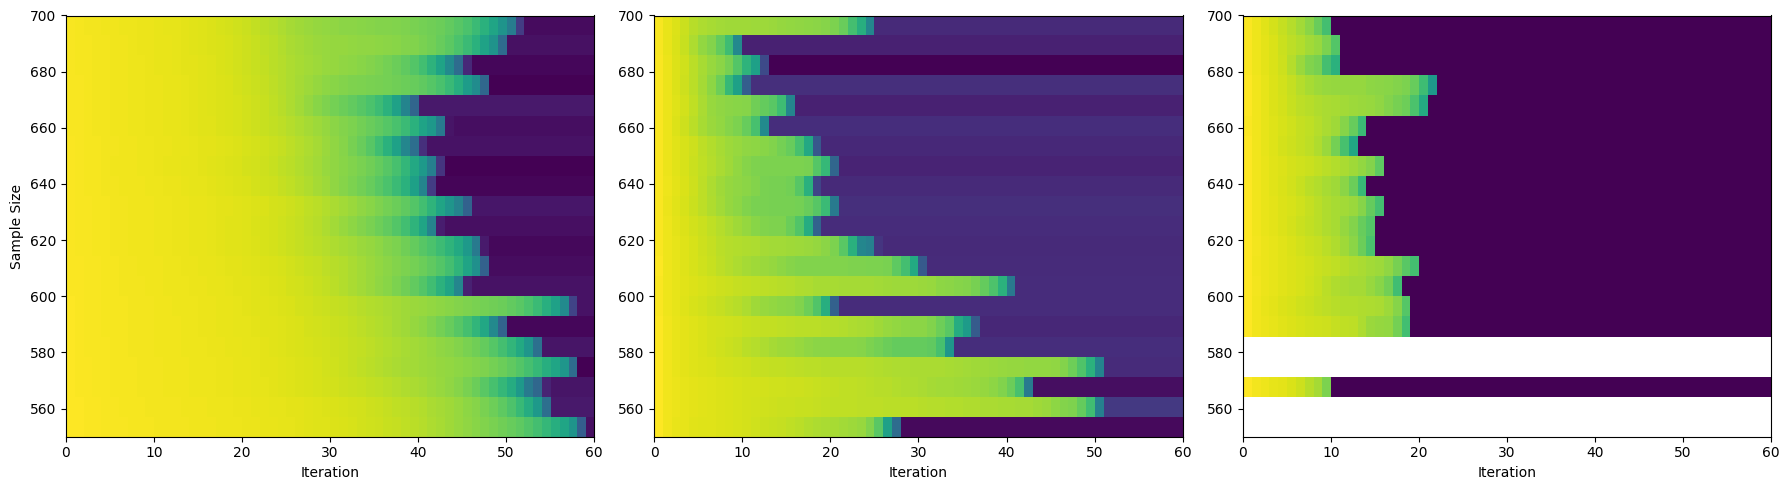

In [77]:
#Convergence time
samples = np.linspace(550, 700, 21)
max_iter = 60                          
errh_bsl = convergence_time_heavy_tail(bwgd_smooth_loss, init="spec2", samples=samples, max_iter=max_iter, square=False)
errh_bs = convergence_time_heavy_tail(bwgd_smooth, init="spec2", samples=samples, max_iter=max_iter, square=False)
errh_b = convergence_time_heavy_tail(bwgd, init="spec2", samples=samples, max_iter=max_iter, square=True)

errors_spec1 = [errh_bsl, errh_bs, errh_b]

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns
for i, (ax, err_matrix) in enumerate(zip(axs, errors_spec1)):
    im = ax.imshow(np.log10(err_matrix.T),  # Transpose for correct orientation
                   aspect='auto',
                   origin='lower',
                   extent=[0, max_iter, samples[0], samples[-1]],
                   cmap='viridis')
    
    ax.set_xlabel('Iteration')
    if i == 0:
        ax.set_ylabel('Sample Size')
    ax.grid(False)

# Add one shared colorbar
cbar.set_label('log(Error)')

plt.tight_layout()
plt.show()
